In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from MapTools_py import map_elements as mel

import statsmodels.api as sm
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

font = {'size'   : 14}

matplotlib.rc('font', **font)

BBECA = gpd.read_file('BB_Data/Spatial/ECOSYS_REV_TEM.shp')
BBECA = BBECA[['PRISTINE', 'ECO', 'MAP_UNIT', 'geometry']]

PS = 'Evergreen Shrubs'
BS = 'Sedge'
FRD = 'Cold Deciduous'
FR = 'Evergreen'
DS = 'Deciduous Shrubs'
WA = 'Ponds'
DIST = 'Disturbed'

Classes = {
    'Water Lily - Watersh':WA,
    'Herb. veg on dist. p':DS,
    'Open Water':WA,
    'Cultivated Field':DIST,
    'Disturbed Surface':DIST,
    'Hardhack Thicket':DS,
    'Birch Forest':FRD,
    'Mixed Conifer Forest':FR,
    'Pine-Salal Forest':FR,
    'Pine Sphagnum Woodla':PS,
    'Beakrush - Three-way':BS,
    'Pine Sphagnum Tall S':PS,
    'Beakrush - Sphagnum':BS,
    'Pine Sphagnum Low Sh':PS,
}

Colors ={
    PS:'#e3f772',#yellow green
    BS:'#76bd68',#light green
    FRD:'#0eb0a5',#dark teal
    FR:'#193d02',#dark green
    DS:'#f5b44c',#light orange
    WA:'#053ba8',#dark blue
    DIST:'grey'
}

print(Colors)

BBECA['PFT'] = BBECA['MAP_UNIT']
BBECA['PFT'] = BBECA['PFT'].replace(Classes)

BBECA.loc[BBECA['PFT']=='Other','MAP_UNIT']='Other'

BBECA['AREA_sqKM']=BBECA.area.values/1e6

Towers = gpd.read_file('BB_Data/Spatial/Towers.shp')
Towers.loc[Towers['Name']=='Sapling_NoTreatment','Name']='BBS'
Towers['X'] = Towers.geometry.x
Towers['Y'] = Towers.geometry.y

BurnZones = gpd.read_file('BB_Data/Spatial/BurnZones.shp')

Chambers = gpd.read_file('BB_Data/Spatial/Chamber_Sites_2016_Burn_Zone.shp')
for eco_type in BBECA['MAP_UNIT'].unique():
    unit = BBECA.loc[BBECA['MAP_UNIT']==eco_type].dissolve().geometry[0]
    Chambers.loc[Chambers.geometry.intersects(unit)==True,'Unit'] = eco_type.replace(
        'Pine Sphagnum ','').replace('Low Sh','Low Shurb').replace('Tall S','Tall Shurb').replace('Woodla','Woodland')

Chambers=Chambers[['geometry','Unit']].copy()

Grid = gpd.read_file('BB_Data/Spatial/SeedlingRemoval.shp')
Grid.loc[Grid['year_done']!='2024','Treatment']='Seedling Removal'
Grid.loc[Grid['year_done']=='2024','Treatment']='Control'
Grid = Grid[['geometry','Treatment']].copy()
Grid = Grid.dissolve(by='Treatment')

for i,row in Grid.iterrows():
    unit = row.geometry
    Chambers.loc[Chambers.geometry.intersects(unit)==True,'Treatment'] = i
    Chambers.loc[Chambers.geometry.intersects(unit)==True,'Zone'] = 2016
    
Chambers['Treatment']=Chambers['Treatment'].fillna('Control')
Chambers['Zone']=Chambers['Zone'].fillna(2005)

Chambers.loc[Chambers['Treatment']=='Seedling Removal','marker']='^'
Chambers.loc[Chambers['Treatment']=='Control','marker']='v'

Chambers['geometry'] = Chambers.buffer(50)
Chambers = Chambers.dissolve(by=['Unit','Treatment','Zone'])

Chambers['geometry']=Chambers.geometry.centroid



Chambers = Chambers.reset_index()

NDVI = pd.read_csv('BB_Data/BBECA_Annual_NDVI.csv',parse_dates={'Date':['system:time_start']},index_col='Date')

rename = {
    'Water':WA,
    # 'Pine\nSphagnum':PS
}

NDVI = NDVI.rename(columns=rename)

NDVI = NDVI.drop('Ponds',axis=1)

Eco = BBECA[['PFT','AREA_sqKM','geometry']].dissolve(by='PFT',aggfunc='sum')
Eco['Pct']=Eco['AREA_sqKM']/Eco['AREA_sqKM'].sum()
Eco = Eco.sort_values(by='Pct')
Eco.loc[Eco.index!='Disturbed'].to_file('BB_Data/Ecosystem_Summary.shp')


for key,color in Colors.items():
    Eco.loc[Eco.index==key,'Color']=color
    
Eco

{'Evergreen Shrubs': '#e3f772', 'Sedge': '#76bd68', 'Cold Deciduous': '#0eb0a5', 'Evergreen': '#193d02', 'Deciduous Shrubs': '#f5b44c', 'Ponds': '#053ba8', 'Disturbed': 'grey'}


,geometry,AREA_sqKM,Pct,Color
PFT,,,,
Ponds,"MULTIPOLYGON (((499585.656 5439869.500, 499587...",0.805043,0.026922,#053ba8
Cold Deciduous,"MULTIPOLYGON (((500016.375 5437614.000, 500017...",1.352961,0.045246,#0eb0a5
Disturbed,"MULTIPOLYGON (((497963.156 5439784.500, 497957...",1.635015,0.054678,grey
Deciduous Shrubs,"MULTIPOLYGON (((500017.219 5437575.000, 500015...",1.642366,0.054924,#f5b44c
Evergreen,"MULTIPOLYGON (((501761.500 5439277.000, 501775...",3.406008,0.113904,#193d02
Sedge,"MULTIPOLYGON (((500933.469 5439790.500, 500937...",6.954329,0.232566,#76bd68
Evergreen Shrubs,"MULTIPOLYGON (((498978.531 5439140.000, 498999...",14.106852,0.471760,#e3f772


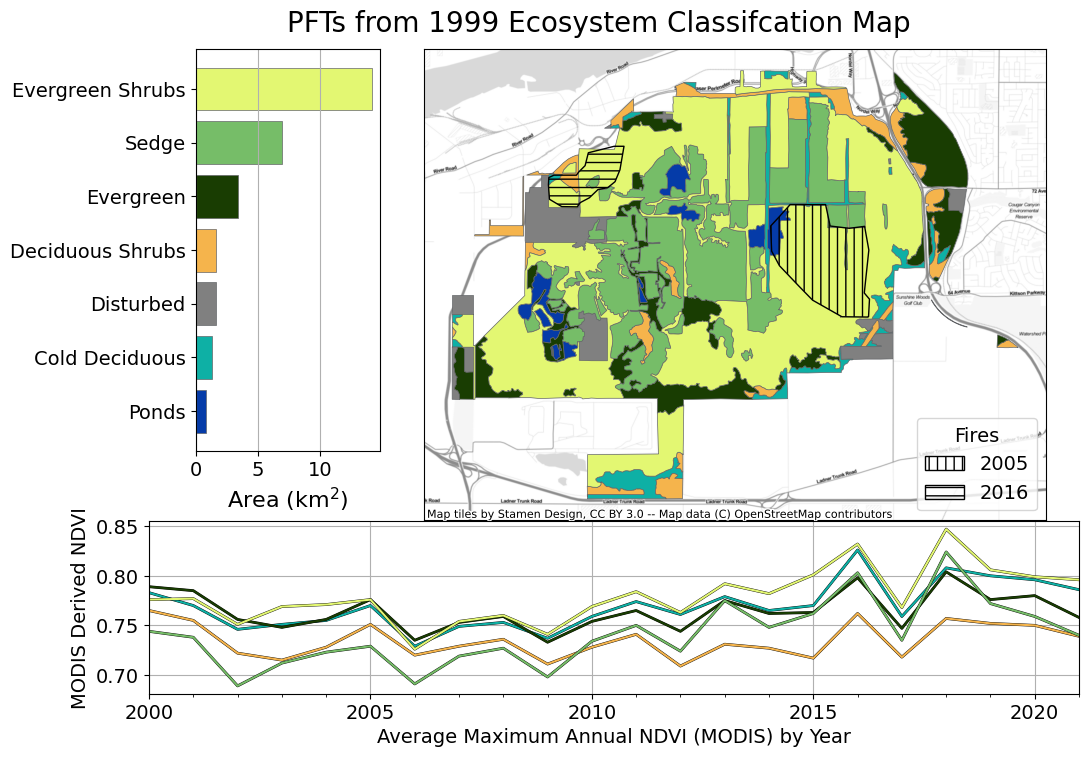

In [2]:
fig = plt.figure(figsize=(12,9))
gs = gridspec.GridSpec(100, 100)
bar=fig.add_subplot(gs[7:65, 5:25])
map=fig.add_subplot(gs[7:75, 26:])
line=fig.add_subplot(gs[75:, 0:])
Class_Patches = []
bar_ylbl = []
bar_ytick = []
for index,row in Eco.iterrows():
    kwargs = {
        'facecolor':row['Color'],
        'linewidth':.5,
        'edgecolor':'#646669'
        }
    Eco.loc[Eco.index==index].plot(ax=map,**kwargs)
    bar.barh(index,row['AREA_sqKM'],
             **kwargs)
    try:
        NDVI[index].plot(ax=line,color='k',linewidth=2)
        NDVI[index].plot(ax=line,color=row['Color'],linewidth=1.5)
    except:
        pass

bar.grid(axis='x')
bar.set_xlabel('Area (km$^2$)',fontsize=16)

kwargs = {
    'edgecolor':'k',
    'hatch':'||',
    'facecolor':'None',
    'label':'2005'
    }
Patches = []
Patches.append(mpatches.Patch(**kwargs))
BurnZones.loc[BurnZones['Year']==2005].plot(
    ax=map,**kwargs)

kwargs['label']='2016'
kwargs['hatch']='--'

Patches.append(mpatches.Patch(**kwargs))
BurnZones.loc[BurnZones['Year']==2016].plot(
    ax=map,**kwargs)

map.get_xaxis().set_visible(False)
map.get_yaxis().set_visible(False)
# map.set_title(
map.legend(handles=(Patches), loc=4,title='Fires')

line.set_ylabel('MODIS Derived NDVI')
line.grid()
line.set_xlabel('Average Maximum Annual NDVI (MODIS) by Year')

cx.add_basemap(map,source=cx.providers.Stamen.TonerLite, crs=Eco.crs, zoom=14)
plt.suptitle('PFTs from 1999 Ecosystem Classifcation Map',y=0.87,fontsize=20)
# plt.tight_layout()
plt.savefig('images/EcosystemMap.png',dpi=300)


In [40]:
# fig = plt.figure(figsize=(10,10))
# gs = gridspec.GridSpec(100, 100)
# bar=fig.add_subplot(gs[7:63, 0:20])
# map=fig.add_subplot(gs[0:70, 21:])
# line=fig.add_subplot(gs[71:, 0:])
# Class_Patches = []
# bar_ylbl = []
# bar_ytick = []
# for index,row in Eco.iterrows():
#     kwargs = {
#         'facecolor':row['Color'],
#         'linewidth':.5,
#         'edgecolor':'#646669'
#         }
#     Eco.loc[Eco.index==index].plot(ax=map,**kwargs)
#     bar.barh(index,row['AREA_sqKM'],
#              **kwargs)
# bar.grid(axis='x')
# bar.set_xlabel('Area (km$^2$)')
# bar.set_title('Ecosystems')

# # kwargs = {
# #     'marker':'s',
# #     'facecolor':'r',
# #     'edgecolor':'k',
# #     's':50
# #     }

# # label_pad = 45

# # BB = Towers.loc[Towers['Name']!='BBS']
# # map.scatter(BB['X'],BB['Y'],
# #            label='Long-Term',
# #            **kwargs)
# # for i,row in BB.iterrows():
# #     map.text(row['X']+label_pad,row['Y']+label_pad,f'est. {int(row.Start)}',color='white')

# # kwargs['marker'] = 'o'
# # BBS = Towers.loc[Towers['Name']=='BBS']
# # map.scatter(BBS['X'],BBS['Y'],
# #            label='Mobile',
# #            **kwargs)
# # for i,row in BBS.iterrows():
# #     map.text(row['X']+label_pad,row['Y']+label_pad,f'est. *2023',color='white')

# # kwargs['facecolor'] ='white'
# # for treat in Chambers['Treatment'].unique():
# #     row = Chambers.loc[((Chambers['Zone']==2016)&(Chambers['Treatment']==treat))]
# #     kwargs['marker'] = row['marker'].iloc[0]
# #     map.scatter(row.geometry.x,row.geometry.y,
# #            label=treat,
# #            **kwargs)

# # handles, labels = map.get_legend_handles_labels()
# # handles.insert(0,'Flux Towers')
# # labels.insert(0,'')

# # handles.insert(3,'Chamber Plots')
# # labels.insert(3,'')
# # map.legend(handles=(handles),labels=(labels),loc=4,
# #            handler_map={str: mel.LegendTitle({'fontsize': 14})})
# map.get_xaxis().set_visible(False)
# map.get_yaxis().set_visible(False)
# map.set_title('Burns Bog Ecological Conservancy Area')

# cx.add_basemap(map,source=cx.providers.Stamen.TonerLite, crs=Eco.crs, zoom=14)
# plt.savefig('images/EcosystemMap.png',dpi=500)


In [4]:


# NDVI.plot()

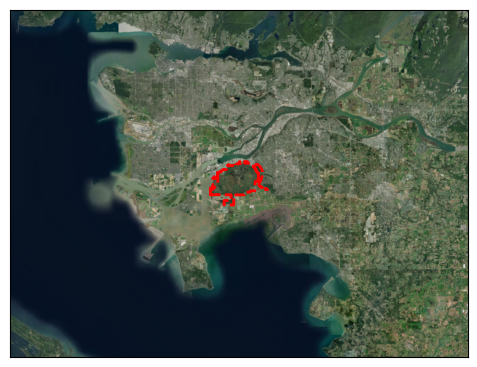

In [5]:

Boundary = BBECA[['geometry']].dissolve().explode(index_parts=True)
Boundary = Boundary.to_crs(epsg=3857)

Scale = 35000

fig,ax=plt.subplots(figsize=(5,5))

access_token='pk.eyJ1IjoidWJjbWljcm9tZXQiLCJhIjoiY2xmMnJzYzlnMGFsYTNxcW1kYWhubjBiaSJ9.rhIOVatxQoS4M__qIFv6Pg'

tileurl = 'https://api.mapbox.com/v4/mapbox.satellite/{z}/{x}/{y}@2x.png?access_token=' + str(access_token)

# tileurl = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}'

Boundary.plot(ax=ax,facecolor='None',edgecolor='red',linewidth=2,linestyle='--')
xl = ax.get_xlim()
yl = ax.get_ylim()

aspect = ((xl[0]-xl[1])/(yl[0]-yl[1]))

ax.set_ylim(yl[0]-Scale,yl[1]+Scale)
ax.set_xlim(xl[0]-Scale*aspect,xl[1]+Scale*aspect)

cx.add_basemap(ax,source=tileurl, zoom=12)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.tight_layout()
plt.savefig('images/Basemap.png',dpi=300)

In [ ]:
# import rasterio as rio
# import numpy as np
# from rasterio.plot import show
# from rasterio.warp import calculate_default_transform, reproject, Resampling
# path = "/mnt/g/My Drive/earthengine/"
# name = "S2_Summer_Composite.tif"
# new_name = "S2_Summer_Composite_projected.tif"


In [ ]:
# BBECA.crs


# dst_crs = 'EPSG:26910'

# Projected_Image = 'temp/FI_Projected.tif'

# with rio.open(path+name) as src:
#     transform, width, height = calculate_default_transform(
#         src.crs, dst_crs, src.width, src.height, *src.bounds)
#     kwargs = src.meta.copy()
#     kwargs.update({
#         'crs': dst_crs,
#         'transform': transform,
#         'width': width,
#         'height': height
#     })

#     with rio.open(Projected_Image, 'w', **kwargs) as dst:
#         for i in range(1, src.count + 1):
#             # clip = pct_clip(rio.band(src, i))
#             reproject(
#                 source=rio.band(src, i),
#                 destination=rio.band(dst, i),
#                 src_transform=src.transform,
#                 src_crs=src.crs,
#                 dst_transform=transform,
#                 dst_crs=dst_crs,
#                 resampling=Resampling.nearest)

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Van = pd.read_csv("BB_Data/VANCOUVER INT'L A.csv",parse_dates=['LOCAL_DATE'],low_memory=False)
# BB1 = pd.read_csv("BB_Data/VANCOUVER INTL A.csv",parse_dates=['LOCAL_DATE'],low_memory=False)

# Van = pd.concat(
#     [Van,BB1]
# )

# Van = Van.set_index('LOCAL_DATE')

# print(Van['PRECIP_AMOUNT'].describe())

# Van = Van[['TEMP','PRECIP_AMOUNT']].resample('Y').sum()
# Van

                            OLS Regression Results                            
Dep. Variable:                     ET   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                 2.407e+04
Date:                Wed, 19 Apr 2023   Prob (F-statistic):               0.00
Time:                        07:26:12   Log-Likelihood:                 55252.
No. Observations:               34811   AIC:                        -1.105e+05
Df Residuals:                   34808   BIC:                        -1.105e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
VPD            0.0135   6.21e-05    216.740      0.0

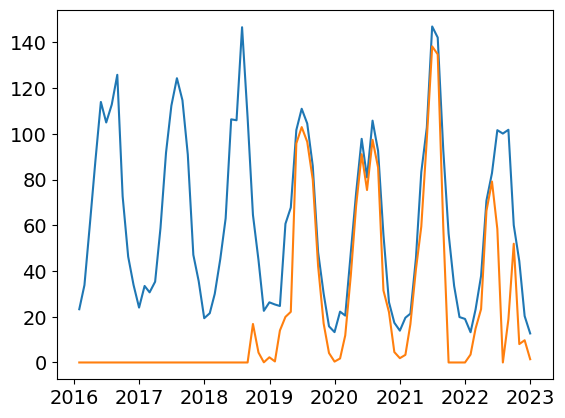

In [8]:


BB1 = pd.read_csv('BB_Data/BB1_Climate.csv',parse_dates={'Date':[0]},low_memory=False)
BB1 = BB1.set_index('Date')
BB1 = BB1.loc[BB1.index.year<=2022]

BB1.loc[BB1['ET']<=0,'ET']=np.nan
# BB1


Temp = BB1[['ET','VPD','P']].dropna()

X = sm.add_constant(Temp[['VPD','P']],prepend=False)
mod = sm.OLS(Temp['ET'], X)


X = sm.add_constant(BB1[['VPD','P']],prepend=False)

res = mod.fit()


BB1['ET_est']=BB1['ET'].fillna(res.predict(X))

fig,ax = plt.subplots()
ax.plot(BB1.resample('M').sum()['ET_est'] )
ax.plot(BB1.resample('M').sum()['ET'] )
# ax.scatter(BB1['ET'],BB1['VPD'])
# ax.scatter(BB1['ET_est'],BB1['VPD'],color='red')

print(res.summary())

print(BB1.mean()['TA'])
print(BB1.resample('Y').sum()[['P','ET_est']].mean())

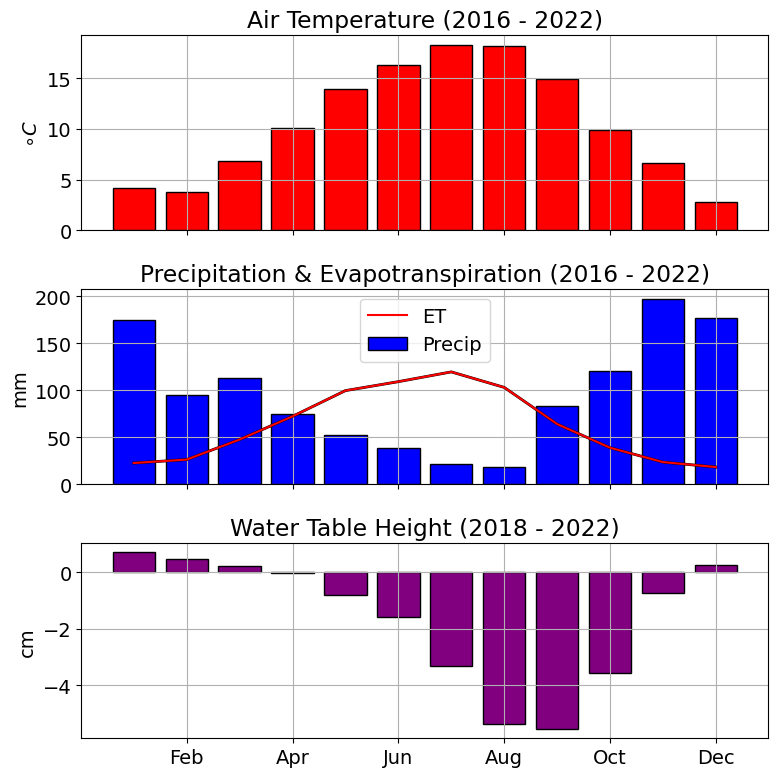

In [9]:
# import pandas as pd
# import matplotlib.pyplot as plt

# BB1 = pd.read_csv('BB_Data/BB1_Climate.csv',parse_dates={'Date':[0]},low_memory=False)
# BB1 = BB1.set_index('Date')
# BB1 = BB1.loc[BB1.index.year<=2022]


BB1_m = BB1[['TA']].groupby(BB1.index.month).mean()
BB1_ym = BB1[['P','ET_est']].resample('m').sum()
BB1_m[['P','ET']] = BB1_ym.groupby(BB1_ym.index.month).mean()
# BB1_m['ET'] = BB1_ym.groupby(BB1_ym.index.month).mean()['ET_est']

WTD=pd.read_csv('BB_Data/BB1_WTD_Corrected.csv',parse_dates=['Date'],index_col=['Date'])

kwargs = {'color':'red','edgecolor':'k'}

fig,ax=plt.subplots(3,figsize=(8,8),sharex=True)
ax[0].bar(BB1_m.index,BB1_m['TA'],**kwargs)
ax[0].grid()
ax[0].set_ylabel('$\circ C$')
ax[0].set_title('Air Temperature (2016 - 2022)')

kwargs['color']='blue'
ax[1].bar(BB1_m.index,BB1_m['P'],**kwargs,label='Precip')
ax[1].plot(BB1_m.index,BB1_m['ET'],color='k',linewidth=2)
ax[1].plot(BB1_m.index,BB1_m['ET'],color='r',linewidth=1.5,label='ET')
ax[1].grid()
ax[1].set_ylabel('mm')
ax[1].set_title('Precipitation & Evapotranspiration (2016 - 2022)')
ax[1].legend()

kwargs['color'] = 'purple'

WTD_m = WTD.groupby(WTD.index.month).mean()
ax[2].bar(WTD_m.index,WTD_m['WTD_est'],**kwargs)
ax[2].grid()
ax[2].set_ylabel('cm')
ax[2].set_title('Water Table Height (2018 - 2022)')
ax[2].set_xticks([2,4,6,8,10,12])
ax[2].set_xticklabels(['Feb','Apr','Jun','Aug','Oct','Dec'])

plt.tight_layout()
plt.savefig('images/Climatology.png',dpi=300)

In [70]:
print(BB1['TA'].mean().round(2))
from scipy import stats

# BB1['ET']=BB1['ET'].interpolate()

print('Balance: ',np.round(BB1['ET'].mean()*48*356,2),np.round(BB1['P'].mean()*48*356,2))

print(np.round(BB1['P'].std()/(BB1['P'].count()**.5)*stats.t.ppf(0.95,BB1['P'].count())*48*356,2))
BB1

10.5
Balance:  736.48 1137.41
21.36


,P,TA,ET
Date,,,
2016-01-01 00:30:00.000003328,0.0,-5.254056,NaN
2016-01-01 00:59:59.999996672,0.0,-4.869694,NaN
2016-01-01 01:30:00.000000000,0.0,-4.534694,NaN
2016-01-01 02:00:00.000003328,0.0,-4.130424,NaN
2016-01-01 02:29:59.999996672,0.0,-4.812542,NaN
...,...,...,...
2022-12-31 21:30:00.000003328,0.0,3.239040,NaN
2022-12-31 21:59:59.999996672,0.0,3.637281,NaN
2022-12-31 22:30:00.000000000,0.0,2.872108,NaN


In [73]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# sudo mount -a

Clim = pd.DataFrame()

for y in range(2016,2024):

    Dir = f'/mnt/w/{y}/BB'

    WL = '/Met/MET_WaterLevel_Avg'
    BH = '/Met/MET_Bog_Height_Avg'
    P = '/Clean/SecondStage/P_1_1_1'
    TA = '/Clean/SecondStage/TA_1_1_1'
    ET = '/Flux/Clean/ET'
    VPD = '/Clean/SecondStage/VPD_1_1_1'
    Time = '/Met/clean_tv'
    WL = Dir + WL
    BH = Dir + BH
    P = Dir + P
    TA = Dir + TA
    ET = Dir + ET
    VPD = Dir + VPD
    time_file = Dir + Time

    Time = np.fromfile(open(time_file, mode='rb'), 'float64')
    # WL = np.fromfile(open(WL, mode='rb'), 'float32')
    # BH = np.fromfile(open(BH, mode='rb'), 'float32')
    P = np.fromfile(open(P, mode='rb'), 'float32')
    TA = np.fromfile(open(TA, mode='rb'), 'float32')
    ET = np.fromfile(open(ET, mode='rb'), 'float32')
    VPD = np.fromfile(open(VPD, mode='rb'), 'float32')
    
    Time = pd.to_datetime(Time-719529,unit='D')

    Clim = pd.concat([
        Clim,
        pd.DataFrame(index=Time,data={'P':P,'TA':TA,'ET':ET,'VPD':VPD})
        ])


Clim = Clim.loc[Clim.index.year<=2023]
Clim.to_csv('BB_Data/BB1_Climate.csv')
Clim.head()


,P,TA,ET,VPD
2016-01-01 00:30:00.000003328,0.0,-5.254056,NaN,0.207189
2016-01-01 00:59:59.999996672,0.0,-4.869694,NaN,0.211804
2016-01-01 01:30:00.000000000,0.0,-4.534694,NaN,0.221776
2016-01-01 02:00:00.000003328,0.0,-4.130424,NaN,0.283990
2016-01-01 02:29:59.999996672,0.0,-4.812541,NaN,0.264534


                                 OLS Regression Results                                
Dep. Variable:                     ET   R-squared (uncentered):                   0.700
Model:                            OLS   Adj. R-squared (uncentered):              0.700
Method:                 Least Squares   F-statistic:                          1.105e+05
Date:                Tue, 18 Apr 2023   Prob (F-statistic):                        0.00
Time:                        01:09:41   Log-Likelihood:                          80022.
No. Observations:               47460   AIC:                                 -1.600e+05
Df Residuals:                   47459   BIC:                                 -1.600e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

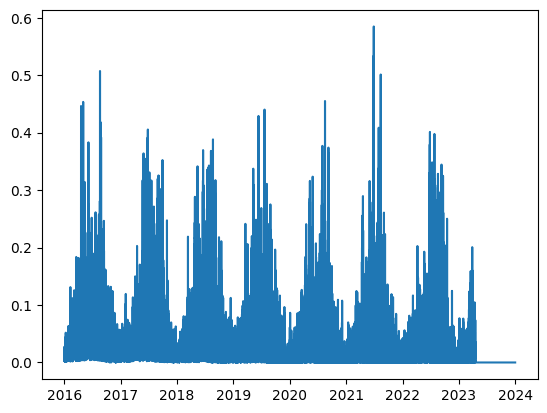

In [117]:
# WTD.to_csv('BB_Data/BB1.WTD')
# WTD.resample('D').mean().plot(kind='scatter',x='WL',y='BH')
WTD = pd.read_csv('BB_Data/BB1.WTD',parse_dates={'Date':[0]})
WTD = WTD.set_index('Date')
WTD = WTD.resample('30T').nearest()

WTD_Man = pd.read_csv('BB_Data/BBFluxWell_SaraKnox.csv',skiprows=3,parse_dates=['Date'])
WTD_Man = WTD_Man.set_index(WTD_Man['Date'])

WTD_Man = WTD_Man.drop('Date',axis=1)
# WTD
WTD_Man['Pipe'] = WTD_Man[['Ground_centralWell_westSideofPipe','Ground_centralWell_southSideofPipe']].mean(axis=1)

WTD_Man['WTD']=WTD_Man['Pipe']-WTD_Man['WT_centralWell']

WTD_Man = WTD_Man.resample('30T').last()

WTD = WTD.join(WTD_Man[['WTD','Pipe']])
WTD_BU = WTD.copy()

                            OLS Regression Results                            
Dep. Variable:                    WTD   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     201.8
Date:                Mon, 17 Apr 2023   Prob (F-statistic):           2.48e-16
Time:                        17:27:50   Log-Likelihood:                -53.523
No. Observations:                  38   AIC:                             111.0
Df Residuals:                      36   BIC:                             114.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
WL             0.2299      0.016     14.207      0.0

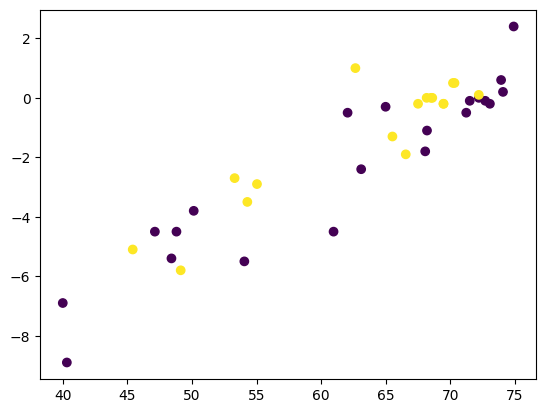

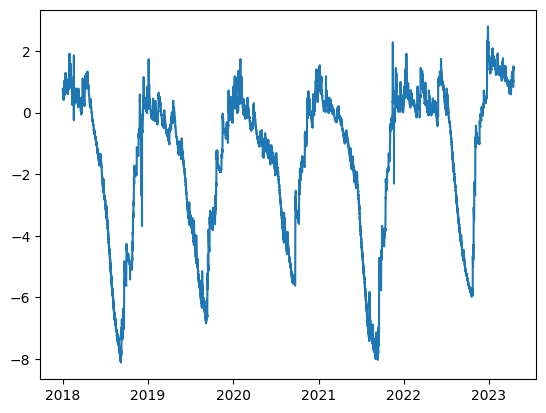

In [118]:


WTD = WTD[['WL','WTD']].dropna()
fig,ax=plt.subplots()
ax.scatter(WTD['WL'],WTD['WTD'],c=WTD.index.year)

X = sm.add_constant(WTD['WL'],prepend=False)

mod = sm.OLS(WTD['WTD'], X)

res = mod.fit()

X = sm.add_constant(WTD_BU['WL'],prepend=False)

WTD_BU['WTD_est'] = res.predict(X)

fig,ax = plt.subplots()
ax.plot(WTD_BU.index,WTD_BU['WTD_est'] )

print(res.summary())

WTD_BU.to_csv('BB_Data/BB1_WTD_Corrected.csv')